In [1]:
%matplotlib inline
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array

In [3]:
df = pd.read_csv('data/FCOJ/fcoj_merged.csv')
print(df.shape)
df.head()

(3593, 66)


,Time,H07,H08,H09,H10,H11,H12,H13,H14,H15,...,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19
0,2005-08-02,-0.013870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-08-03,-0.002232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005-08-04,-0.006652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2005-08-05,0.003114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005-08-08,0.046555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
contract3 = df.loc[ (df['Time'] >= '2007-08-02') & (df['Time'] <= '2009-03-10') , ['Time', 'H09']]
contract3.shape

(402, 2)

In [5]:
w = pd.read_csv('data/master_weather_norm.csv')
w.head()

,date,prcp_van,prcp_tor,prcp_den,prcp_avon,prcp_pierce,prcp_lake,prcp_moore,prcp_orlan,prcp_sdo,...,difftavg_tor,difftavg_den,difftavg_avon,difftavg_pierce,difftavg_lake,difftavg_moore,difftavg_orlan,difftavg_sdo,difftavg_sfo,difftavg_nyc
0,2007-01-01,0.275928,-0.386119,-0.276021,-0.288200,-0.274641,-0.108700,-0.336117,-0.340801,-0.18008,...,2.173860,-1.631648e-18,1.286402,1.058969,0.564631,0.837325,1.064431,0.159788,0.693336,1.887613
1,2007-01-02,-0.414591,-0.386119,-0.276021,0.381056,-0.274641,-0.135922,-0.336117,0.123214,-0.18008,...,2.059904,-1.631648e-18,0.979247,1.074357,-0.097086,0.829169,0.116795,0.633641,0.990234,1.678849
2,2007-01-03,1.384393,-0.386119,-0.276021,-0.288200,-0.274641,-0.272032,-0.336117,0.915905,-0.18008,...,2.536975,-1.631648e-18,0.975376,0.991123,1.526549,0.939272,2.464650,-0.187337,0.732808,2.055595
3,2007-01-04,-0.414591,0.174167,-0.276021,-0.288200,-0.274641,-0.244810,-0.336117,-0.340801,0.10805,...,2.674109,-1.631648e-18,3.172668,2.615715,2.061799,2.108264,2.476595,-0.297536,-0.487394,2.380878
4,2007-01-05,-0.414591,0.734453,-0.276021,-0.288200,-0.235577,-0.362772,-0.336117,-0.340801,-0.18008,...,3.076899,-1.631648e-18,2.760746,2.452276,2.018366,2.066126,2.139481,-0.725473,-0.351816,3.300410


In [6]:
cont3_w = w[(w['date'] >= '2007-08-02') & (w['date'] <= '2009-03-10')]
cont3_w.shape

(586, 67)

In [7]:
data = cont3_w.merge(contract3, how = 'left', left_on = 'date', right_on = 'Time')
data.drop('Time', axis = 1, inplace = True)


#should deal with missing value... why there is missing value (some days are not there) in contact datsets ???
#for now --> ffill
data= data.fillna(method = 'ffill', axis = 0)

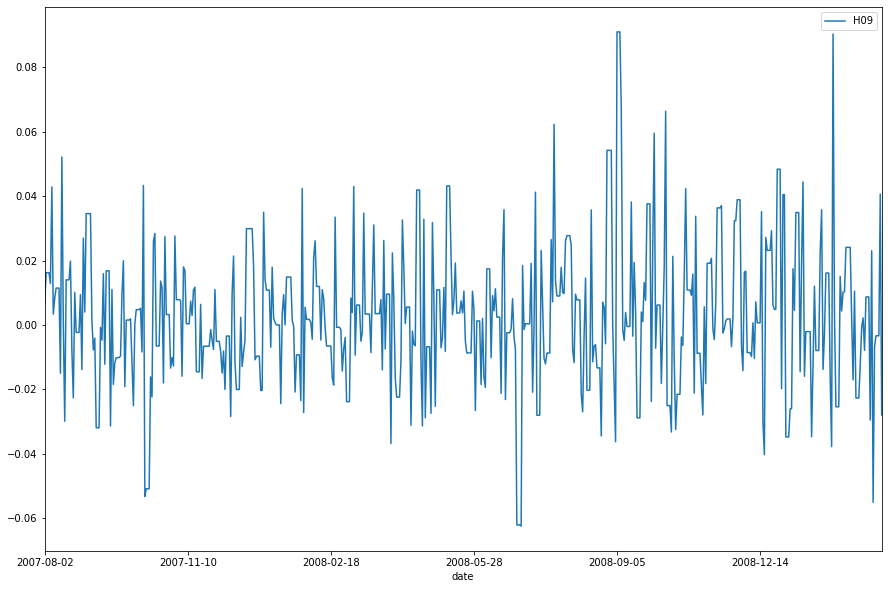

In [8]:
data.plot('date', 'H09' , figsize = (15, 10))
plt.show()

In [9]:
data.set_index('date', inplace=True)

In [10]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    #df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(data.H09.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars-1,n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars-1,n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [11]:
def fit_lstm(train,test, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    train_X, train_y = train[:, :n_lag*data.shape[1]], train[:, n_lag*data.shape[1]:]
    test_X, test_y = test[:, :n_lag*data.shape[1]], test[:, n_lag*data.shape[1]:]
    
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
#     X, y = train[:, 0:n_lag], train[:, n_lag:]
#     X = X.reshape(X.shape[0], 1, X.shape[1])

    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, train_X.shape[1], train_X.shape[2]), stateful=True))
    model.add(Dense(train_y.shape[1]))
    model.compile(loss='mae', optimizer='adam')
#     fit network
#     for i in range(nb_epoch):
#         history = model.fit(train_X, train_y, epochs=1, batch_size=n_batch, validation_data=(test_X, test_y),
#                             verbose=2, shuffle=False)

    history = model.fit(train_X, train_y, epochs=nb_epoch, batch_size=n_batch, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    model.reset_states()
    return model

In [12]:
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

In [13]:
# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag*data.shape[1]], test[i, n_lag*data.shape[1]:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

In [14]:
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    actual_all = [row[n_lag*data.shape[1]:] for row in test]
    for i in range(n_seq):
        actual = [row[i] for row in actual_all]        
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))
        r_sq = r2_score(actual, predicted)
        print('t+%d R-sq: %f' % ((i+1), r_sq))
        print('*****')

In [15]:
# configure
n_lag = 40
n_seq = 10
# n_epochs = 20
# n_batch = 1

supervised = series_to_supervised(data, n_lag, n_seq)

In [16]:
supervised.head()

,var1(t-40),var2(t-40),var3(t-40),var4(t-40),var5(t-40),var6(t-40),var7(t-40),var8(t-40),var9(t-40),var10(t-40),...,var67(t),var67(t+1),var67(t+2),var67(t+3),var67(t+4),var67(t+5),var67(t+6),var67(t+7),var67(t+8),var67(t+9)
date,,,,,,,,,,,,,,,,,,,,,
2007-09-11,-0.414591,-0.386119,1.615420,0.507983,2.108269,3.049047,0.632386,0.103880,-0.18008,-0.266867,...,-0.004706,0.015936,-0.012200,0.016807,0.016807,0.016807,-0.031395,0.010972,-0.018462,-0.011783
2007-09-12,-0.414591,-0.386119,1.027540,0.415672,-0.251202,-0.317402,-0.336117,-0.340801,-0.18008,-0.266867,...,0.015936,-0.012200,0.016807,0.016807,0.016807,-0.031395,0.010972,-0.018462,-0.011783,-0.010158
2007-09-13,-0.414591,-0.386119,2.970101,-0.288200,1.053539,-0.362772,3.977214,-0.340801,-0.18008,-0.266867,...,-0.012200,0.016807,0.016807,0.016807,-0.031395,0.010972,-0.018462,-0.011783,-0.010158,-0.010158
2007-09-14,-0.414591,-0.386119,1.410940,-0.288200,-0.274641,-0.362772,-0.336117,-0.340801,-0.18008,-0.266867,...,0.016807,0.016807,0.016807,-0.031395,0.010972,-0.018462,-0.011783,-0.010158,-0.010158,-0.010158
2007-09-15,-0.414591,-0.386119,1.078660,-0.288200,-0.274641,-0.362772,-0.336117,-0.340801,-0.18008,-0.266867,...,0.016807,0.016807,-0.031395,0.010972,-0.018462,-0.011783,-0.010158,-0.010158,-0.010158,-0.009687


In [17]:
# split into train and test sets
values = supervised.values
n_train_days = 400 # first 400 days
train = values[:n_train_days, :]
test = values[n_train_days:, :] #137 days
print(train.shape, test.shape)

(400, 2690) (137, 2690)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 400 samples, validate on 137 samples
Epoch 1/30
 - 4s - loss: 0.0627 - val_loss: 0.0455
Epoch 2/30
 - 2s - loss: 0.0461 - val_loss: 0.0544
Epoch 3/30
 - 2s - loss: 0.0348 - val_loss: 0.0405
Epoch 4/30
 - 2s - loss: 0.0282 - val_loss: 0.0515
Epoch 5/30
 - 2s - loss: 0.0237 - val_loss: 0.0412
Epoch 6/30
 - 2s - loss: 0.0216 - val_loss: 0.0318
Epoch 7/30
 - 2s - loss: 0.0205 - val_loss: 0.0323
Epoch 8/30
 - 2s - loss: 0.0224 - val_loss: 0.0399
Epoch 9/30
 - 2s - loss: 0.0204 - val_loss: 0.0362
Epoch 10/30
 - 2s - loss: 0.0207 - val_loss: 0.0418
Epoch 11/30
 - 2s - loss: 0.0204 - val_loss: 0.0430
Epoch 12/30
 - 2s - loss: 0.0203 - val_loss: 0.0435
Epoch 13/30
 - 2s - loss: 0.0201 - val_loss: 0.0453
Epoch 14/30
 - 2s - loss: 0.0198 - val_loss: 0.0436
Epoch 15/30
 - 2s - loss: 0.0200 - val_loss: 0.0410
Epoch 16/30
 - 2s - loss: 0.0204 - val_loss: 0.0398
Epoch 17/30

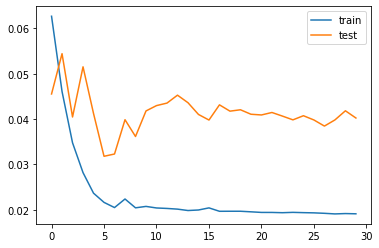

In [18]:
model = fit_lstm(train,test, 40, 10, 1, 30, 10)

In [19]:
# make forecasts
forecasts = make_forecasts(model, 1, train, test, 40, 10)

In [22]:
evaluate_forecasts(test, forecasts, n_lag, n_seq)

t+1 RMSE: 0.080112
t+1 R-sq: -11.336686
*****
t+2 RMSE: 0.081441
t+2 R-sq: -11.586649
*****
t+3 RMSE: 0.065972
t+3 R-sq: -7.384927
*****
t+4 RMSE: 0.033807
t+4 R-sq: -1.115221
*****
t+5 RMSE: 0.055225
t+5 R-sq: -4.687963
*****
t+6 RMSE: 0.112501
t+6 R-sq: -22.812270
*****
t+7 RMSE: 0.037360
t+7 R-sq: -1.626237
*****
t+8 RMSE: 0.065155
t+8 R-sq: -6.994528
*****
t+9 RMSE: 0.048558
t+9 R-sq: -3.371821
*****
t+10 RMSE: 0.068464
t+10 R-sq: -7.724914
*****
